# LCCNN - Previsão de Mortalidade
## Treinamento Global + Fine-tuning Brasil
### Teste: 2015-2019 | Previsões: 2020-2070

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


In [3]:
# Carregar os dados
df = pd.read_csv('/content/df_all.csv')
print(f'Dataset carregado: {df.shape}')
print(f'Colunas: {list(df.columns)}')
print(f'Anos disponíveis: {df["Year"].min()} - {df["Year"].max()}')
print(f'Países únicos: {df["Country"].nunique()}')
print(f'Gêneros: {sorted(df["Gender"].unique())}')

# Identificar colunas de grupos etários
exclude_cols = ['Country', 'Year', 'Gender']
age_columns = sorted([col for col in df.columns if col not in exclude_cols], key=lambda x: int(x))
print(f'Grupos etários: {age_columns}')

Dataset carregado: (7744, 23)
Colunas: ['Country', 'Year', '0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', 'Gender']
Anos disponíveis: 1950 - 2023
Países únicos: 82
Gêneros: [np.int64(0), np.int64(1)]
Grupos etários: ['0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90']


In [4]:
# Função para calcular sMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Função para calcular intervalos de confiança
def calculate_confidence_intervals(predictions, residuals, confidence=0.95):
    """
    Calcula intervalos de confiança baseados nos resíduos do modelo
    """
    alpha = 1 - confidence
    std_residuals = np.std(residuals)
    z_score = 1.96  # Para 95% de confiança

    margin_error = z_score * std_residuals
    lower_bound = predictions - margin_error
    upper_bound = predictions + margin_error

    return lower_bound, upper_bound

In [5]:
# Função para preparar dados globais (todos os países)
def prepare_global_data(df, gender_code, sequence_length=10, start_year=1950):
    """
    Prepara dados globais para treinamento inicial
    """
    print(f'\n=== PREPARANDO DADOS GLOBAIS - GÊNERO {gender_code} ===')

    # Filtrar por gênero e ano
    global_data = df[(df['Gender'] == gender_code) & (df['Year'] >= start_year)].copy()
    print(f'Dados globais filtrados: {len(global_data)} registros')
    print(f'Países: {global_data["Country"].nunique()}')
    print(f'Anos: {global_data["Year"].min()} - {global_data["Year"].max()}')

    # Preparar dados para cada grupo etário
    global_processed = {}
    global_scalers = {}

    for age_col in age_columns:
        print(f'Processando grupo etário {age_col}...')

        # Coletar todas as séries temporais deste grupo etário
        all_series = []

        for country in global_data['Country'].unique():
            country_data = global_data[global_data['Country'] == country].sort_values('Year')
            if len(country_data) >= sequence_length + 1:  # Mínimo para criar sequências
                series = country_data[age_col].values
                all_series.extend(series)

        if len(all_series) == 0:
            continue

        # Normalizar dados globais
        scaler = MinMaxScaler()
        all_series = np.array(all_series).reshape(-1, 1)
        normalized_global = scaler.fit_transform(all_series)

        # Criar sequências globais
        X_global, y_global = [], []

        for country in global_data['Country'].unique():
            country_data = global_data[global_data['Country'] == country].sort_values('Year')
            if len(country_data) >= sequence_length + 1:
                series = country_data[age_col].values.reshape(-1, 1)
                series_norm = scaler.transform(series)

                # Criar sequências para este país
                for i in range(sequence_length, len(series_norm)):
                    X_global.append(series_norm[i-sequence_length:i, 0])
                    y_global.append(series_norm[i, 0])

        if len(X_global) > 0:
            global_processed[age_col] = {
                'X': np.array(X_global),
                'y': np.array(y_global)
            }
            global_scalers[age_col] = scaler
            print(f'Grupo {age_col}: {len(X_global)} sequências criadas')

    return global_processed, global_scalers

In [6]:
# Função para preparar dados do Brasil
def prepare_brazil_data(df, gender_code, sequence_length=10):
    """
    Prepara dados específicos do Brasil para fine-tuning e teste
    """
    print(f'\n=== PREPARANDO DADOS DO BRASIL - GÊNERO {gender_code} ===')

    # Filtrar dados do Brasil (Country=49)
    brazil_data = df[(df['Country'] == 49) & (df['Gender'] == gender_code)].copy()
    brazil_data = brazil_data.sort_values('Year')

    print(f'Dados do Brasil: {len(brazil_data)} registros')
    print(f'Anos: {brazil_data["Year"].min()} - {brazil_data["Year"].max()}')

    # Dividir dados por período
    train_data = brazil_data[brazil_data['Year'] < 2015]  # Treino: antes de 2015
    test_data = brazil_data[(brazil_data['Year'] >= 2015) & (brazil_data['Year'] <= 2019)]  # Teste: 2015-2019

    print(f'Dados de treino (fine-tuning): {len(train_data)} registros ({train_data["Year"].min()}-{train_data["Year"].max()})')
    print(f'Dados de teste: {len(test_data)} registros ({test_data["Year"].min()}-{test_data["Year"].max()})')

    brazil_processed = {}

    for age_col in age_columns:
        # Dados de treino (fine-tuning)
        train_series = train_data[age_col].values
        test_series = test_data[age_col].values

        if len(train_series) >= sequence_length + 1 and len(test_series) > 0:
            # Usar toda a série do Brasil para normalização
            full_series = brazil_data[age_col].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            scaler.fit(full_series)

            # Normalizar séries de treino e teste
            train_norm = scaler.transform(train_series.reshape(-1, 1))
            test_norm = scaler.transform(test_series.reshape(-1, 1))

            # Criar sequências de fine-tuning
            X_finetune, y_finetune = [], []
            for i in range(sequence_length, len(train_norm)):
                X_finetune.append(train_norm[i-sequence_length:i, 0])
                y_finetune.append(train_norm[i, 0])

            # Criar sequências de teste
            # Usar os últimos dados de treino + dados de teste
            combined_series = np.concatenate([train_norm[-sequence_length:], test_norm])
            X_test, y_test = [], []
            for i in range(sequence_length, len(combined_series)):
                X_test.append(combined_series[i-sequence_length:i, 0])
                y_test.append(combined_series[i, 0])

            if len(X_finetune) > 0 and len(X_test) > 0:
                brazil_processed[age_col] = {
                    'X_finetune': np.array(X_finetune),
                    'y_finetune': np.array(y_finetune),
                    'X_test': np.array(X_test),
                    'y_test': np.array(y_test),
                    'scaler': scaler,
                    'full_series': brazil_data[age_col].values,
                    'years': brazil_data['Year'].values
                }
                print(f'Grupo {age_col}: {len(X_finetune)} seq. fine-tuning, {len(X_test)} seq. teste')

    return brazil_processed

In [7]:
# Função para criar modelo LCCNN
def create_lccnn_model(sequence_length=10, n_features=1):
    """
    Cria modelo LCCNN (LSTM + CNN)
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [8]:
# Preparar dados globais para homens
global_data_male, global_scalers_male = prepare_global_data(df, gender_code=0)


=== PREPARANDO DADOS GLOBAIS - GÊNERO 0 ===
Dados globais filtrados: 3872 registros
Países: 82
Anos: 1950 - 2023
Processando grupo etário 0...
Grupo 0: 3052 sequências criadas
Processando grupo etário 1...
Grupo 1: 3052 sequências criadas
Processando grupo etário 5...
Grupo 5: 3052 sequências criadas
Processando grupo etário 10...
Grupo 10: 3052 sequências criadas
Processando grupo etário 15...
Grupo 15: 3052 sequências criadas
Processando grupo etário 20...
Grupo 20: 3052 sequências criadas
Processando grupo etário 25...
Grupo 25: 3052 sequências criadas
Processando grupo etário 30...
Grupo 30: 3052 sequências criadas
Processando grupo etário 35...
Grupo 35: 3052 sequências criadas
Processando grupo etário 40...
Grupo 40: 3052 sequências criadas
Processando grupo etário 45...
Grupo 45: 3052 sequências criadas
Processando grupo etário 50...
Grupo 50: 3052 sequências criadas
Processando grupo etário 55...
Grupo 55: 3052 sequências criadas
Processando grupo etário 60...
Grupo 60: 3052 s

In [9]:
# Preparar dados globais para mulheres
global_data_female, global_scalers_female = prepare_global_data(df, gender_code=1)


=== PREPARANDO DADOS GLOBAIS - GÊNERO 1 ===
Dados globais filtrados: 3872 registros
Países: 82
Anos: 1950 - 2023
Processando grupo etário 0...
Grupo 0: 3052 sequências criadas
Processando grupo etário 1...
Grupo 1: 3052 sequências criadas
Processando grupo etário 5...
Grupo 5: 3052 sequências criadas
Processando grupo etário 10...
Grupo 10: 3052 sequências criadas
Processando grupo etário 15...
Grupo 15: 3052 sequências criadas
Processando grupo etário 20...
Grupo 20: 3052 sequências criadas
Processando grupo etário 25...
Grupo 25: 3052 sequências criadas
Processando grupo etário 30...
Grupo 30: 3052 sequências criadas
Processando grupo etário 35...
Grupo 35: 3052 sequências criadas
Processando grupo etário 40...
Grupo 40: 3052 sequências criadas
Processando grupo etário 45...
Grupo 45: 3052 sequências criadas
Processando grupo etário 50...
Grupo 50: 3052 sequências criadas
Processando grupo etário 55...
Grupo 55: 3052 sequências criadas
Processando grupo etário 60...
Grupo 60: 3052 s

In [10]:
# Preparar dados do Brasil para homens
brazil_data_male = prepare_brazil_data(df, gender_code=0)


=== PREPARANDO DADOS DO BRASIL - GÊNERO 0 ===
Dados do Brasil: 24 registros
Anos: 2000 - 2023
Dados de treino (fine-tuning): 15 registros (2000-2014)
Dados de teste: 5 registros (2015-2019)
Grupo 0: 5 seq. fine-tuning, 5 seq. teste
Grupo 1: 5 seq. fine-tuning, 5 seq. teste
Grupo 5: 5 seq. fine-tuning, 5 seq. teste
Grupo 10: 5 seq. fine-tuning, 5 seq. teste
Grupo 15: 5 seq. fine-tuning, 5 seq. teste
Grupo 20: 5 seq. fine-tuning, 5 seq. teste
Grupo 25: 5 seq. fine-tuning, 5 seq. teste
Grupo 30: 5 seq. fine-tuning, 5 seq. teste
Grupo 35: 5 seq. fine-tuning, 5 seq. teste
Grupo 40: 5 seq. fine-tuning, 5 seq. teste
Grupo 45: 5 seq. fine-tuning, 5 seq. teste
Grupo 50: 5 seq. fine-tuning, 5 seq. teste
Grupo 55: 5 seq. fine-tuning, 5 seq. teste
Grupo 60: 5 seq. fine-tuning, 5 seq. teste
Grupo 65: 5 seq. fine-tuning, 5 seq. teste
Grupo 70: 5 seq. fine-tuning, 5 seq. teste
Grupo 75: 5 seq. fine-tuning, 5 seq. teste
Grupo 80: 5 seq. fine-tuning, 5 seq. teste
Grupo 85: 5 seq. fine-tuning, 5 seq. t

In [11]:
# Preparar dados do Brasil para mulheres
brazil_data_female = prepare_brazil_data(df, gender_code=1)


=== PREPARANDO DADOS DO BRASIL - GÊNERO 1 ===
Dados do Brasil: 24 registros
Anos: 2000 - 2023
Dados de treino (fine-tuning): 15 registros (2000-2014)
Dados de teste: 5 registros (2015-2019)
Grupo 0: 5 seq. fine-tuning, 5 seq. teste
Grupo 1: 5 seq. fine-tuning, 5 seq. teste
Grupo 5: 5 seq. fine-tuning, 5 seq. teste
Grupo 10: 5 seq. fine-tuning, 5 seq. teste
Grupo 15: 5 seq. fine-tuning, 5 seq. teste
Grupo 20: 5 seq. fine-tuning, 5 seq. teste
Grupo 25: 5 seq. fine-tuning, 5 seq. teste
Grupo 30: 5 seq. fine-tuning, 5 seq. teste
Grupo 35: 5 seq. fine-tuning, 5 seq. teste
Grupo 40: 5 seq. fine-tuning, 5 seq. teste
Grupo 45: 5 seq. fine-tuning, 5 seq. teste
Grupo 50: 5 seq. fine-tuning, 5 seq. teste
Grupo 55: 5 seq. fine-tuning, 5 seq. teste
Grupo 60: 5 seq. fine-tuning, 5 seq. teste
Grupo 65: 5 seq. fine-tuning, 5 seq. teste
Grupo 70: 5 seq. fine-tuning, 5 seq. teste
Grupo 75: 5 seq. fine-tuning, 5 seq. teste
Grupo 80: 5 seq. fine-tuning, 5 seq. teste
Grupo 85: 5 seq. fine-tuning, 5 seq. t

In [12]:
# Função para treinar modelo global + fine-tuning + previsões
def train_global_finetune_predict(global_data, brazil_data, gender_name):
    """
    Treina modelo global, faz fine-tuning no Brasil e gera previsões
    """
    models = {}
    predictions_dict = {}
    metrics_dict = {}

    print(f'\n=== TREINAMENTO GLOBAL + FINE-TUNING - {gender_name.upper()} ===')

    for age_group in brazil_data.keys():
        if age_group not in global_data:
            print(f'Grupo {age_group} não disponível nos dados globais')
            continue

        print(f'\n--- Processando grupo etário {age_group} ---')

        try:
            # 1. TREINAMENTO GLOBAL
            print('1. Treinamento global...')
            X_global = global_data[age_group]['X']
            y_global = global_data[age_group]['y']

            # Reshape para LSTM
            X_global = X_global.reshape((X_global.shape[0], X_global.shape[1], 1))

            # Criar e treinar modelo global
            global_model = create_lccnn_model(sequence_length=X_global.shape[1])

            # Treinar modelo global
            global_model.fit(X_global, y_global,
                            epochs=30,
                            batch_size=64,
                            verbose=0,
                            validation_split=0.2)

            print(f'Modelo global treinado com {len(X_global)} sequências')

            # 2. FINE-TUNING NO BRASIL
            print('2. Fine-tuning no Brasil...')
            X_finetune = brazil_data[age_group]['X_finetune']
            y_finetune = brazil_data[age_group]['y_finetune']
            X_test = brazil_data[age_group]['X_test']
            y_test = brazil_data[age_group]['y_test']

            # Reshape para LSTM
            X_finetune = X_finetune.reshape((X_finetune.shape[0], X_finetune.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

            # Clonar modelo global para fine-tuning
            finetuned_model = clone_model(global_model)
            finetuned_model.set_weights(global_model.get_weights())
            finetuned_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

            # Fine-tuning com learning rate menor
            finetuned_model.fit(X_finetune, y_finetune,
                              epochs=50,
                              batch_size=16,
                              verbose=0)

            print(f'Fine-tuning realizado com {len(X_finetune)} sequências')

            # 3. AVALIAÇÃO NO PERÍODO DE TESTE (2015-2019)
            print('3. Avaliação no período de teste...')
            y_pred = finetuned_model.predict(X_test, verbose=0)

            # Desnormalizar previsões
            scaler = brazil_data[age_group]['scaler']
            y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
            y_pred_orig = scaler.inverse_transform(y_pred).flatten()

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
            mae = mean_absolute_error(y_test_orig, y_pred_orig)
            smape_val = smape(y_test_orig, y_pred_orig)

            metrics_dict[age_group] = {
                'RMSE': rmse,
                'MAE': mae,
                'sMAPE': smape_val
            }

            print(f'Métricas - RMSE: {rmse:.6f}, MAE: {mae:.6f}, sMAPE: {smape_val:.2f}%')

            # 4. PREVISÕES 2020-2070
            print('4. Gerando previsões 2020-2070...')

            # Usar os últimos dados disponíveis como sequência inicial
            full_series = brazil_data[age_group]['full_series']
            full_series_norm = scaler.transform(full_series.reshape(-1, 1))
            last_sequence = full_series_norm[-10:].reshape(1, -1, 1)  # Últimos 10 valores

            future_predictions = []
            residuals = y_test_orig - y_pred_orig

            for year in range(2020, 2071):
                pred = finetuned_model.predict(last_sequence, verbose=0)
                future_predictions.append(pred[0, 0])

                # Atualizar sequência para próxima previsão
                last_sequence = np.roll(last_sequence, -1, axis=1)
                last_sequence[0, -1, 0] = pred[0, 0]

            # Desnormalizar previsões futuras
            future_predictions = np.array(future_predictions).reshape(-1, 1)
            future_predictions_orig = scaler.inverse_transform(future_predictions).flatten()

            # Calcular intervalos de confiança
            lower_bound, upper_bound = calculate_confidence_intervals(future_predictions_orig, residuals)

            predictions_dict[age_group] = {
                'years': list(range(2020, 2071)),
                'predictions': future_predictions_orig,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

            models[age_group] = finetuned_model
            print(f'Previsões geradas para 2020-2070')

        except Exception as e:
            print(f'Erro ao processar grupo {age_group}: {str(e)}')
            continue

    return models, predictions_dict, metrics_dict

In [13]:
# Treinar modelos para homens
if brazil_data_male and global_data_male:
    models_male, predictions_male, metrics_male = train_global_finetune_predict(
        global_data_male, brazil_data_male, 'homens')
else:
    print('Dados insuficientes para homens')
    models_male, predictions_male, metrics_male = {}, {}, {}


=== TREINAMENTO GLOBAL + FINE-TUNING - HOMENS ===

--- Processando grupo etário 0 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000486, MAE: 0.000378, sMAPE: 2.71%
4. Gerando previsões 2020-2070...
Previsões geradas para 2020-2070

--- Processando grupo etário 1 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000019, MAE: 0.000014, sMAPE: 2.55%
4. Gerando previsões 2020-2070...
Previsões geradas para 2020-2070

--- Processando grupo etário 5 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000015, MAE: 0.000015, sMAPE: 5.74%
4. Gerando previsões 2020-207

In [14]:
# Treinar modelos para mulheres
if brazil_data_female and global_data_female:
    models_female, predictions_female, metrics_female = train_global_finetune_predict(
        global_data_female, brazil_data_female, 'mulheres')
else:
    print('Dados insuficientes para mulheres')
    models_female, predictions_female, metrics_female = {}, {}, {}


=== TREINAMENTO GLOBAL + FINE-TUNING - MULHERES ===

--- Processando grupo etário 0 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000412, MAE: 0.000354, sMAPE: 3.04%
4. Gerando previsões 2020-2070...
Previsões geradas para 2020-2070

--- Processando grupo etário 1 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000025, MAE: 0.000023, sMAPE: 4.95%
4. Gerando previsões 2020-2070...
Previsões geradas para 2020-2070

--- Processando grupo etário 5 ---
1. Treinamento global...
Modelo global treinado com 3052 sequências
2. Fine-tuning no Brasil...
Fine-tuning realizado com 5 sequências
3. Avaliação no período de teste...
Métricas - RMSE: 0.000008, MAE: 0.000007, sMAPE: 3.60%
4. Gerando previsões 2020-2

In [15]:
# Função para criar CSV de previsões
def create_predictions_csv(predictions_dict, gender_name, local='Brasil'):
    """
    Cria CSV com previsões no formato especificado
    """
    rows = []

    for age_group, pred_data in predictions_dict.items():
        for i, year in enumerate(pred_data['years']):
            rows.append({
                'Local': local,
                'Sexo': gender_name,
                'Ano': year,
                'Grupo Etário': age_group,
                'Previsão': pred_data['predictions'][i],
                'Limite Inferior': pred_data['lower_bound'][i],
                'Limite Superior': pred_data['upper_bound'][i]
            })

    df_predictions = pd.DataFrame(rows)
    filename = f'previsoes_{gender_name.lower()}.csv'
    df_predictions.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_predictions)} registros')
    return df_predictions

# Função para criar CSV de métricas
def create_metrics_csv(metrics_dict, gender_name, local='Brasil'):
    """
    Cria CSV com métricas no formato especificado
    """
    rows = []

    for age_group, metrics in metrics_dict.items():
        rows.append({
            'Local': local,
            'Sexo': gender_name,
            'Grupo Etário': age_group,
            'RMSE': metrics['RMSE'],
            'sMAPE': metrics['sMAPE'],
            'MAE': metrics['MAE']
        })

    df_metrics = pd.DataFrame(rows)
    filename = f'metricas_{gender_name.lower()}.csv'
    df_metrics.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_metrics)} registros')
    return df_metrics

In [16]:
# Gerar arquivos CSV para homens
print('=== GERANDO ARQUIVOS CSV PARA HOMENS ===')
if predictions_male:
    df_pred_male = create_predictions_csv(predictions_male, 'Masculino')
    df_metrics_male = create_metrics_csv(metrics_male, 'Masculino')
    print('Arquivos para homens gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para homens')

=== GERANDO ARQUIVOS CSV PARA HOMENS ===
Arquivo previsoes_masculino.csv criado com 1020 registros
Arquivo metricas_masculino.csv criado com 20 registros
Arquivos para homens gerados com sucesso!


In [17]:
# Gerar arquivos CSV para mulheres
print('=== GERANDO ARQUIVOS CSV PARA MULHERES ===')
if predictions_female:
    df_pred_female = create_predictions_csv(predictions_female, 'Feminino')
    df_metrics_female = create_metrics_csv(metrics_female, 'Feminino')
    print('Arquivos para mulheres gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para mulheres')

=== GERANDO ARQUIVOS CSV PARA MULHERES ===
Arquivo previsoes_feminino.csv criado com 1020 registros
Arquivo metricas_feminino.csv criado com 20 registros
Arquivos para mulheres gerados com sucesso!


In [18]:
# Resumo final
print('\n=== RESUMO FINAL ===')
print('METODOLOGIA:')
print('1. Treinamento global com todos os países (1950+)')
print('2. Fine-tuning específico para o Brasil')
print('3. Teste no Brasil: 2015-2019')
print('4. Previsões: 2020-2070')
print('\nARQUIVOS GERADOS:')
print('• previsoes_masculino.csv - Previsões 2020-2070 para homens')
print('• previsoes_feminino.csv - Previsões 2020-2070 para mulheres')
print('• metricas_masculino.csv - Métricas de erro para homens (teste 2015-2019)')
print('• metricas_feminino.csv - Métricas de erro para mulheres (teste 2015-2019)')
print('\nTodos os arquivos estão prontos para download!')


=== RESUMO FINAL ===
METODOLOGIA:
1. Treinamento global com todos os países (1950+)
2. Fine-tuning específico para o Brasil
3. Teste no Brasil: 2015-2019
4. Previsões: 2020-2070

ARQUIVOS GERADOS:
• previsoes_masculino.csv - Previsões 2020-2070 para homens
• previsoes_feminino.csv - Previsões 2020-2070 para mulheres
• metricas_masculino.csv - Métricas de erro para homens (teste 2015-2019)
• metricas_feminino.csv - Métricas de erro para mulheres (teste 2015-2019)

Todos os arquivos estão prontos para download!


In [20]:
# Carregar previsões para homens
df_pred_male = pd.read_csv('previsoes_masculino.csv')
df_pred_male

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.013248,0.012649,0.013848
1,Brasil,Masculino,2021,0,0.013307,0.012708,0.013906
2,Brasil,Masculino,2022,0,0.013329,0.012730,0.013929
3,Brasil,Masculino,2023,0,0.013334,0.012735,0.013933
4,Brasil,Masculino,2024,0,0.013342,0.012743,0.013941
...,...,...,...,...,...,...,...
1015,Brasil,Masculino,2066,90,0.199908,0.196198,0.203617
1016,Brasil,Masculino,2067,90,0.199619,0.195910,0.203329
1017,Brasil,Masculino,2068,90,0.199334,0.195624,0.203044
1018,Brasil,Masculino,2069,90,0.199051,0.195341,0.202761


In [21]:
# Organizar previsões por ano e depois por grupo etário
df_pred_male = df_pred_male.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_male

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.013248,0.012649,0.013848
51,Brasil,Masculino,2020,1,0.000508,0.000482,0.000535
102,Brasil,Masculino,2020,5,0.000227,0.000222,0.000232
153,Brasil,Masculino,2020,10,0.000329,0.000303,0.000354
204,Brasil,Masculino,2020,15,0.001612,0.001306,0.001917
...,...,...,...,...,...,...,...
815,Brasil,Masculino,2070,70,0.031959,0.031850,0.032069
866,Brasil,Masculino,2070,75,0.050150,0.049946,0.050354
917,Brasil,Masculino,2070,80,0.079545,0.079340,0.079750
968,Brasil,Masculino,2070,85,0.137757,0.135273,0.140241


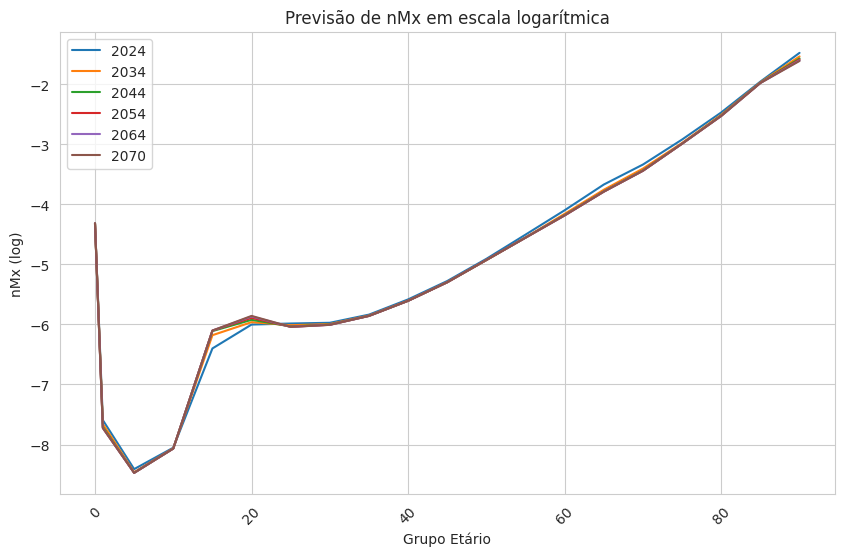

In [22]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [23]:
# Carregar métricas de erros
df_metrics_male

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Masculino,0,0.000486,2.705441,0.000378
1,Brasil,Masculino,1,0.000019,2.546660,0.000014
2,Brasil,Masculino,5,0.000015,5.739518,0.000015
3,Brasil,Masculino,10,0.000045,11.271164,0.000043
4,Brasil,Masculino,15,0.000221,8.118997,0.000159
5,Brasil,Masculino,20,0.000161,3.773879,0.000102
6,Brasil,Masculino,25,0.000125,3.468865,0.000088
7,Brasil,Masculino,30,0.000088,3.053118,0.000080
8,Brasil,Masculino,35,0.000107,3.418928,0.000104
9,Brasil,Masculino,40,0.000124,3.007924,0.000115


In [26]:
# Carregar previsões para mulheres
df_pred_female = pd.read_csv('previsoes_feminino.csv')
df_pred_female

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.010928,0.010205,0.011651
1,Brasil,Feminino,2021,0,0.010939,0.010217,0.011662
2,Brasil,Feminino,2022,0,0.010911,0.010188,0.011634
3,Brasil,Feminino,2023,0,0.010865,0.010142,0.011588
4,Brasil,Feminino,2024,0,0.010827,0.010104,0.011550
...,...,...,...,...,...,...,...
1015,Brasil,Feminino,2066,90,0.194437,0.193119,0.195754
1016,Brasil,Feminino,2067,90,0.194358,0.193041,0.195675
1017,Brasil,Feminino,2068,90,0.194281,0.192963,0.195598
1018,Brasil,Feminino,2069,90,0.194205,0.192887,0.195522


In [27]:
# Organizar previsões de mulheres por ano e grupo etári
df_pred_female = df_pred_female.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_female

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.010928,0.010205,0.011651
51,Brasil,Feminino,2020,1,0.000425,0.000410,0.000441
102,Brasil,Feminino,2020,5,0.000187,0.000179,0.000196
153,Brasil,Feminino,2020,10,0.000236,0.000233,0.000240
204,Brasil,Feminino,2020,15,0.000447,0.000439,0.000454
...,...,...,...,...,...,...,...
815,Brasil,Feminino,2070,70,0.019538,0.019428,0.019648
866,Brasil,Feminino,2070,75,0.034862,0.034407,0.035318
917,Brasil,Feminino,2070,80,0.061672,0.061383,0.061960
968,Brasil,Feminino,2070,85,0.115092,0.112474,0.117710


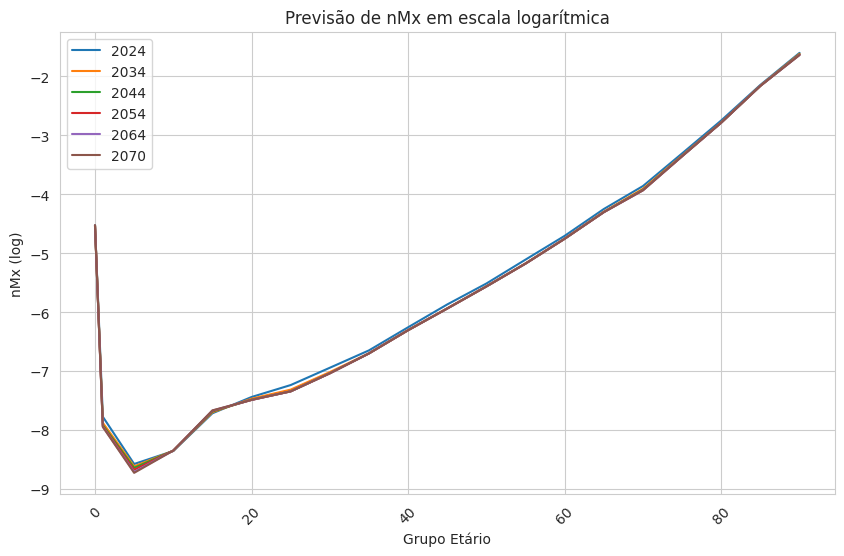

In [28]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()